## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 65.3MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## 分類問題として捉える

In [ ]:
!pip install thundersvm
!pip install japanize-matplotlib
!pip install catboost

     |████████████████████████████████| 507 kB 7.4 MB/s 
     |████████████████████████████████| 4.1 MB 8.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=4999ecc17b0e812ae4a50aff7b49038d4c7a5d0271665f193b9f3ab63a782cc2
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 
from tqdm import tqdm_notebook as tqdm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
df_dropna = df.dropna(subset=["Global_Sales"], axis=0)

### ビン分割処理

In [ ]:
df_dropna["Target"] = pd.cut(
    df_dropna["Global_Sales"], 
    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, df["Global_Sales"].max()+10], 
    right=False, 
    labels=False
    )

### ビンごとにラベル付与

In [ ]:
hit_labels = ['normal', 'milion_hit', 'double_milion_hit', 'triple_milion_hit', 'quadruple_milion_hit', 
              'quintuple_milion_hit', 'sextaple_milion_hit', 'septaple_milion_hit', 'octaple_milion_hit', 
              'nonuple_milion_hit', 'ten_million_hit']

df_dropna["Target_Label"] = pd.cut(
    df_dropna["Global_Sales"], 
    [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, df["Global_Sales"].max()+10], 
    right=False, 
    labels=hit_labels
    )

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df_dropna.drop(["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Target_Label", "Target"], axis=1), 
                                                    df_dropna["Target"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED,
                                                    stratify=df_dropna["Target"],  
                                                    )

## ラベルの分布

In [ ]:
pd.DataFrame(
    [
        df_dropna["Target"].value_counts(normalize=True).sort_index().values,
        y_train.value_counts(normalize=True).sort_index().values,
        y_test.value_counts(normalize=True).sort_index().values,
    ],
    columns = hit_labels,
    index = ["all", "Train", "Test"],
).T

,all,Train,Test
normal,0.915272,0.915232,0.915365
milion_hit,0.053773,0.053790,0.053734
double_milion_hit,0.015349,0.015379,0.015279
triple_milion_hit,0.006541,0.006549,0.006524
quadruple_milion_hit,0.003657,0.003679,0.003605
quintuple_milion_hit,0.001854,0.001840,0.001888
sextaple_milion_hit,0.001185,0.001177,0.001202
septaple_milion_hit,0.000567,0.000589,0.000515
octaple_milion_hit,0.000361,0.000368,0.000343
nonuple_milion_hit,0.000258,0.000221,0.000343


## パイプライン

In [ ]:
# 数値データカラム名を取得
number_columns = X_train.drop("Global_Sales", axis=1).select_dtypes(include="number").columns

# カテゴリデータカラム名を取得
category_columns = X_train.drop("Global_Sales", axis=1).select_dtypes(include="object").columns

# カテゴリデータカラムの各カラムのカテゴリーの数を取得
category_unique_num = X_train.drop("Global_Sales", axis=1).select_dtypes(include="object").nunique()

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーの数にしきい値を設けて、カテゴリー数の多いカラムと少ないカラムに分ける
thread = 10
many_kinds_category_columns = category_unique_num[category_unique_num >= thread].index
few_kinds_category_columns = category_unique_num[category_unique_num < thread].index

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in many_kinds_category_columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)

# カテゴリー数が多いカテゴリーデータ用の変換
many_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
])

# カテゴリー数が少ないカテゴリーデータ用の変換
few_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('many_kinds', many_kinds_categorical_transformer, many_kinds_category_columns),
        ('few_kinds', few_kinds_categorical_transformer, few_kinds_category_columns)
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

# パイプラインの作成
pipe = Pipeline(
    [
        ("columns_transformers", columns_transformers),
        ('model', lgb.LGBMClassifier(
            random_state=42, 
            )
        )
     ]
)

## 学習・推論

fold:0
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.915195,0.053808,0.015361,0.006623,0.003679,0.00184,0.001104,0.000552,0.000368,0.000276,0.001196
Test,0.915379,0.053716,0.015453,0.006255,0.003679,0.00184,0.001472,0.000736,0.000368,NaN,0.001104


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,ten_million_hit
normal,2191,280,7,4,0,2,3,0,1,0
milion_hit,126,20,0,0,0,0,0,0,0,0
double_milion_hit,38,2,2,0,0,0,0,0,0,0
triple_milion_hit,15,1,1,0,0,0,0,0,0,0
quadruple_milion_hit,8,2,0,0,0,0,0,0,0,0
quintuple_milion_hit,4,1,0,0,0,0,0,0,0,0
sextaple_milion_hit,4,0,0,0,0,0,0,0,0,0
septaple_milion_hit,2,0,0,0,0,0,0,0,0,0
octaple_milion_hit,1,0,0,0,0,0,0,0,0,0
ten_million_hit,3,0,0,0,0,0,0,0,0,0


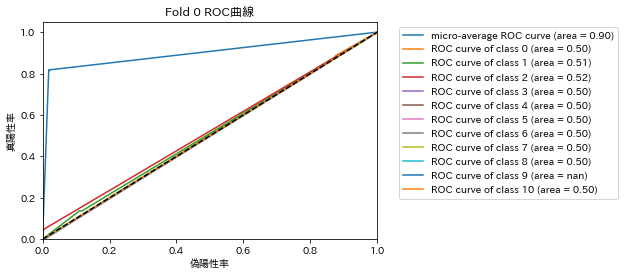



fold:1
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.915195,0.053808,0.015361,0.006531,0.003679,0.00184,0.001196,0.000644,0.000368,0.000276,0.001104
Test,0.915379,0.053716,0.015453,0.006623,0.003679,0.00184,0.001104,0.000368,0.000368,NaN,0.001472


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2306,144,15,4,1,5,0,2,0,4,7
milion_hit,146,0,0,0,0,0,0,0,0,0,0
double_milion_hit,42,0,0,0,0,0,0,0,0,0,0
triple_milion_hit,18,0,0,0,0,0,0,0,0,0,0
quadruple_milion_hit,10,0,0,0,0,0,0,0,0,0,0
quintuple_milion_hit,5,0,0,0,0,0,0,0,0,0,0
sextaple_milion_hit,3,0,0,0,0,0,0,0,0,0,0
septaple_milion_hit,1,0,0,0,0,0,0,0,0,0,0
octaple_milion_hit,1,0,0,0,0,0,0,0,0,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,0,0


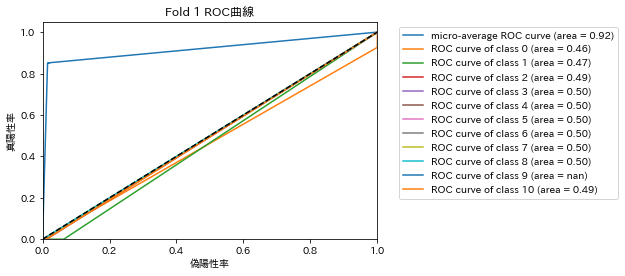



fold:2
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.915195,0.053808,0.015361,0.006531,0.003679,0.00184,0.001196,0.000644,0.000368,0.000184,0.001196
Test,0.915379,0.053716,0.015453,0.006623,0.003679,0.00184,0.001104,0.000368,0.000368,0.000368,0.001104


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2479,6,3,0,0,0,0,0,0,0,0
milion_hit,5,129,6,0,2,0,3,0,0,0,1
double_milion_hit,4,6,10,1,7,1,2,1,3,0,7
triple_milion_hit,1,0,4,10,3,0,0,0,0,0,0
quadruple_milion_hit,2,0,3,0,5,0,0,0,0,0,0
quintuple_milion_hit,0,0,2,1,2,0,0,0,0,0,0
sextaple_milion_hit,0,0,0,2,0,0,0,0,0,0,1
septaple_milion_hit,0,0,0,0,1,0,0,0,0,0,0
octaple_milion_hit,0,0,1,0,0,0,0,0,0,0,0
nonuple_milion_hit,0,0,0,0,0,0,1,0,0,0,0


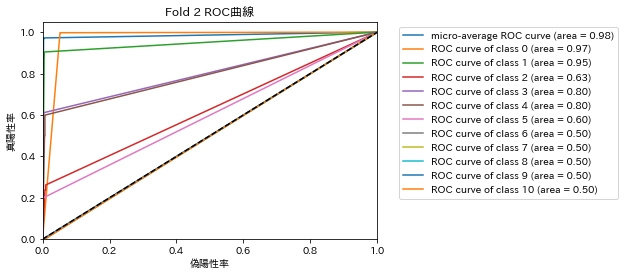



fold:3
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.915287,0.053716,0.015453,0.006531,0.003679,0.00184,0.001196,0.000552,0.000368,0.000184,0.001196
Test,0.915011,0.054084,0.015085,0.006623,0.003679,0.00184,0.001104,0.000736,0.000368,0.000368,0.001104


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2447,21,5,3,4,1,4,0,0,0,2
milion_hit,14,108,5,7,10,0,0,0,0,2,1
double_milion_hit,1,2,37,1,0,0,0,0,0,0,0
triple_milion_hit,2,1,10,4,1,0,0,0,0,0,0
quadruple_milion_hit,0,2,3,1,4,0,0,0,0,0,0
quintuple_milion_hit,0,2,1,0,2,0,0,0,0,0,0
sextaple_milion_hit,0,0,2,0,1,0,0,0,0,0,0
septaple_milion_hit,0,1,0,0,1,0,0,0,0,0,0
octaple_milion_hit,0,0,1,0,0,0,0,0,0,0,0
nonuple_milion_hit,0,0,1,0,0,0,0,0,0,0,0


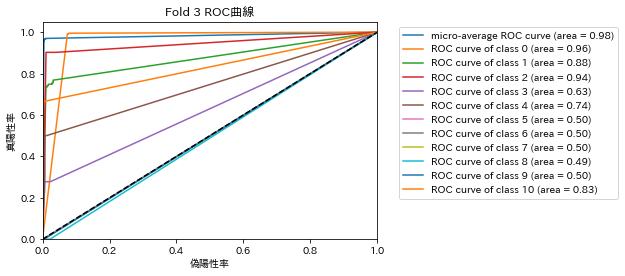



fold:4
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.915287,0.053808,0.015361,0.006531,0.003679,0.00184,0.001196,0.000552,0.000368,0.000184,0.001196
Test,0.915011,0.053716,0.015453,0.006623,0.003679,0.00184,0.001104,0.000736,0.000368,0.000368,0.001104


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2324,8,49,10,2,10,11,33,15,0,25
milion_hit,146,0,0,0,0,0,0,0,0,0,0
double_milion_hit,41,0,1,0,0,0,0,0,0,0,0
triple_milion_hit,18,0,0,0,0,0,0,0,0,0,0
quadruple_milion_hit,10,0,0,0,0,0,0,0,0,0,0
quintuple_milion_hit,4,1,0,0,0,0,0,0,0,0,0
sextaple_milion_hit,3,0,0,0,0,0,0,0,0,0,0
septaple_milion_hit,2,0,0,0,0,0,0,0,0,0,0
octaple_milion_hit,1,0,0,0,0,0,0,0,0,0,0
nonuple_milion_hit,1,0,0,0,0,0,0,0,0,0,0


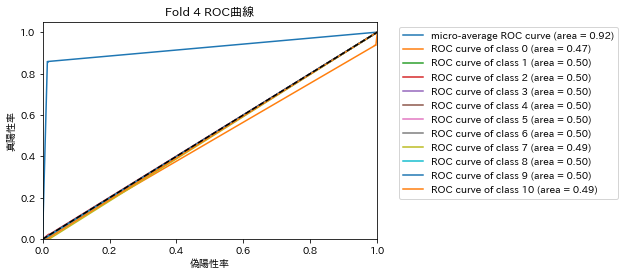

In [ ]:
n_classes = 11

skf = StratifiedKFold(
    n_splits=5, 
    shuffle=True,
    random_state=SEED
    )

cv_result = []
cv_rmse = []

for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_skf, X_test_skf = X_train.drop("Global_Sales", axis=1).iloc[train_index], X_train.drop("Global_Sales", axis=1).iloc[test_index]
    y_train_skf, y_test_skf = y_train.iloc[train_index], y_train.iloc[test_index]

    print(f"fold:{i}")

    # データ分布
    histgram = pd.concat([
            y_train_skf.value_counts(normalize=True).sort_index(),
            y_test_skf.value_counts(normalize=True).sort_index()
        ], axis=1).T
    
    histgram.columns = hit_labels
    histgram.index = ["Train", "Test"]

    print("データ分布")
    display(histgram)

    # 学習、推論
    pipe.fit(X_train_skf, y_train_skf)

    y_pred = pipe.predict(X_test_skf)

    # 混合行列のカラム名の作成
    confuse_matrix_columns = np.concatenate([y_test_skf.unique(), np.unique(y_pred)])
    confuse_matrix_columns = np.unique(confuse_matrix_columns)
    confuse_matrix_columns = [hit_labels[x] for x in confuse_matrix_columns]

    print("混合行列")
    display(
        pd.DataFrame(
            confusion_matrix(y_test_skf, y_pred),
            index = confuse_matrix_columns,
            columns = confuse_matrix_columns
        )
    )

    # ROC曲線
    y_score = pipe.predict_proba(X_test_skf)
    y_test_skf_bin = label_binarize(y_test_skf, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_skf_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_skf_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
    for k in range(n_classes):
        plt.plot(fpr[k], tpr[k], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(k, roc_auc[k]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('偽陽性率')
    plt.ylabel('真陽性率')
    plt.title(f'Fold {i} ROC曲線')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
    print()
    print()

    pred = pipe.predict(X_test.drop("Global_Sales", axis=1))
    score = f1_score(y_test, pred, average="macro")
    cv_result.append(score)

    rmse = mean_squared_error(
            X_test["Global_Sales"], 
            [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, df["Global_Sales"].max()][x] for x in pred],
            squared=False
            )
    cv_rmse.append(rmse)

In [ ]:
print("テストデータ F1Score:", np.mean(cv_result))
print("テストデータ RMSE", np.mean(cv_rmse))

テストデータ F1Score: 0.15898311764016076
テストデータ RMSE 1.2553489368798378


### オーバーサンプリング

### ラベル分布の確認

In [ ]:
pd.DataFrame(
    [
        df_dropna["Target"].value_counts(normalize=True).sort_index().values,
        y_train.value_counts(normalize=True).sort_index().values,
        y_test.value_counts(normalize=True).sort_index().values,
    ],
    columns = hit_labels,
    index = ["all", "Train", "Test"],
).T

,all,Train,Test
normal,0.915272,0.915232,0.915365
milion_hit,0.053773,0.053790,0.053734
double_milion_hit,0.015349,0.015379,0.015279
triple_milion_hit,0.006541,0.006549,0.006524
quadruple_milion_hit,0.003657,0.003679,0.003605
quintuple_milion_hit,0.001854,0.001840,0.001888
sextaple_milion_hit,0.001185,0.001177,0.001202
septaple_milion_hit,0.000567,0.000589,0.000515
octaple_milion_hit,0.000361,0.000368,0.000343
nonuple_milion_hit,0.000258,0.000221,0.000343


## normal の数を基準に、それぞれ何倍にすれば normal と同数になるか出力

In [ ]:
for i in range(len(df_dropna["Target"].value_counts().sort_index())):
    print(
            df_dropna["Target"].value_counts().sort_index().index[i],                                                    # index
            hit_labels[df_dropna["Target"].value_counts().sort_index().index[i]],                                        # ラベル名
            df_dropna["Target"].value_counts().sort_index()[0]//df_dropna["Target"].value_counts().sort_index().iloc[i], # 倍率
            "倍"
        )

0 normal 1 倍
1 milion_hit 17 倍
2 double_milion_hit 59 倍
3 triple_milion_hit 139 倍
4 quadruple_milion_hit 250 倍
5 quintuple_milion_hit 493 倍
6 sextaple_milion_hit 772 倍
7 septaple_milion_hit 1615 倍
8 octaple_milion_hit 2538 倍
9 nonuple_milion_hit 3554 倍
10 ten_million_hit 772 倍


## データの水増し処理

In [ ]:
# 空のDataFrameを作成
X_train_over = pd.DataFrame()
y_train_over = pd.DataFrame()

for i in range(len(df_dropna["Target"].value_counts().sort_index())):

    index_num = df_dropna["Target"].value_counts().sort_index().index[i] # index

    coef = df_dropna["Target"].value_counts().sort_index()[0]//df_dropna["Target"].value_counts().sort_index().iloc[i] # 倍率

    X_train_over = pd.concat([
                              X_train_over,
                              pd.concat([X_train[y_train==index_num]]*coef)
                            ])
    
    y_train_over = pd.concat([
                            y_train_over,
                            pd.concat([y_train[y_train==index_num]]*coef)
                        ])

# index の初期化
X_train_over = X_train_over.reset_index(drop=True)    
y_train_over = y_train_over.reset_index(drop=True)[0] # Series型に戻す
y_train_over = y_train_over.astype(int) # int型に戻す

In [ ]:
print(len(X_train_over), len(y_train_over))
print()
print(y_train_over.value_counts().sort_index())

135368 135368

0     12438
1     12427
2     12331
3     12371
4     12500
5     12325
6     12352
7     12920
8     12690
9     10662
10    12352
Name: 0, dtype: int64


fold:0
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.091880,0.091806,0.091085,0.091390,0.092341,0.091048,0.091252,0.095444,0.093745,0.078758,0.091252
Test,0.091896,0.091785,0.091121,0.091379,0.092340,0.091047,0.091231,0.095442,0.093743,0.078784,0.091231


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2488,0,0,0,0,0,0,0,0,0,0
milion_hit,0,2485,0,0,0,0,0,0,0,0,0
double_milion_hit,0,0,2467,0,0,0,0,0,0,0,0
triple_milion_hit,0,0,0,2474,0,0,0,0,0,0,0
quadruple_milion_hit,0,0,0,0,2500,0,0,0,0,0,0
quintuple_milion_hit,0,0,0,0,0,2465,0,0,0,0,0
sextaple_milion_hit,0,0,0,0,0,0,2470,0,0,0,0
septaple_milion_hit,0,0,0,0,0,0,0,2584,0,0,0
octaple_milion_hit,0,0,0,0,0,0,0,0,2538,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,2133,0


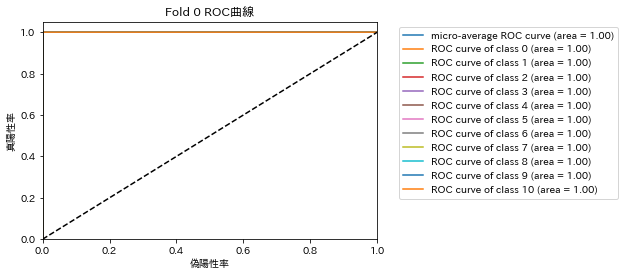



fold:1
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.091880,0.091806,0.091095,0.091381,0.092341,0.091048,0.091252,0.095444,0.093745,0.078767,0.091242
Test,0.091896,0.091785,0.091084,0.091416,0.092340,0.091047,0.091231,0.095442,0.093743,0.078747,0.091268


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2487,1,0,0,0,0,0,0,0,0,0
milion_hit,0,2485,0,0,0,0,0,0,0,0,0
double_milion_hit,0,0,2466,0,0,0,0,0,0,0,0
triple_milion_hit,0,0,0,2475,0,0,0,0,0,0,0
quadruple_milion_hit,0,0,0,0,2500,0,0,0,0,0,0
quintuple_milion_hit,0,0,0,0,0,2465,0,0,0,0,0
sextaple_milion_hit,0,0,0,0,0,0,2470,0,0,0,0
septaple_milion_hit,0,0,0,0,0,0,0,2584,0,0,0
octaple_milion_hit,0,0,0,0,0,0,0,0,2538,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,2132,0


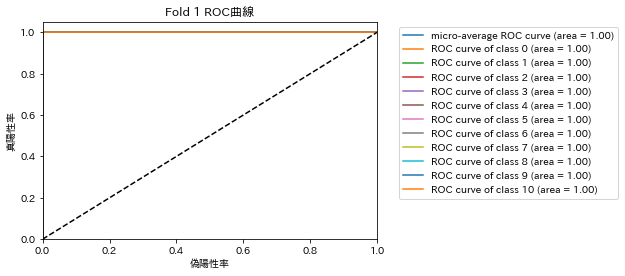



fold:2
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.091880,0.091806,0.091095,0.091390,0.092341,0.091048,0.091242,0.095444,0.093745,0.078767,0.091242
Test,0.091896,0.091785,0.091084,0.091379,0.092340,0.091047,0.091268,0.095442,0.093743,0.078747,0.091268


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2488,0,0,0,0,0,0,0,0,0,0
milion_hit,0,2485,0,0,0,0,0,0,0,0,0
double_milion_hit,0,0,2466,0,0,0,0,0,0,0,0
triple_milion_hit,0,0,0,2474,0,0,0,0,0,0,0
quadruple_milion_hit,0,0,0,0,2500,0,0,0,0,0,0
quintuple_milion_hit,0,0,0,0,0,2465,0,0,0,0,0
sextaple_milion_hit,0,0,0,0,0,0,2471,0,0,0,0
septaple_milion_hit,0,0,0,0,0,0,0,2584,0,0,0
octaple_milion_hit,0,0,0,0,0,0,0,0,2538,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,2132,0


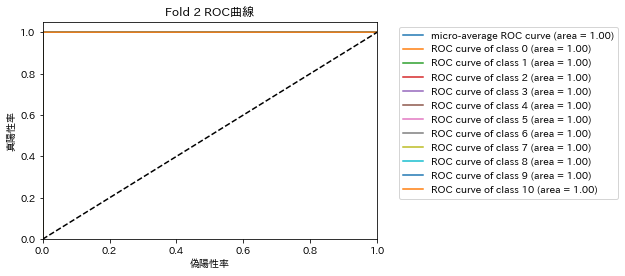



fold:3
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.091888,0.091796,0.091094,0.091389,0.092340,0.091048,0.091242,0.095443,0.093744,0.078766,0.091251
Test,0.091863,0.091826,0.091087,0.091383,0.092343,0.091050,0.091272,0.095446,0.093747,0.078750,0.091235


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2487,0,0,0,0,0,0,0,0,0,0
milion_hit,0,2486,0,0,0,0,0,0,0,0,0
double_milion_hit,0,0,2466,0,0,0,0,0,0,0,0
triple_milion_hit,0,0,0,2474,0,0,0,0,0,0,0
quadruple_milion_hit,0,0,0,0,2500,0,0,0,0,0,0
quintuple_milion_hit,0,0,0,0,0,2465,0,0,0,0,0
sextaple_milion_hit,0,0,0,0,0,0,2471,0,0,0,0
septaple_milion_hit,0,0,0,0,0,0,0,2584,0,0,0
octaple_milion_hit,0,0,0,0,0,0,0,0,2538,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,2132,0


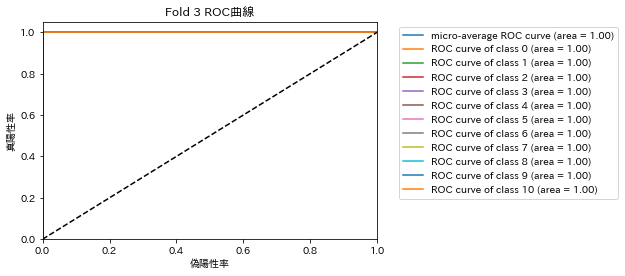



fold:4
データ分布


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
Train,0.091888,0.091796,0.091094,0.091389,0.092340,0.091048,0.091251,0.095443,0.093744,0.078757,0.091251
Test,0.091863,0.091826,0.091087,0.091383,0.092343,0.091050,0.091235,0.095446,0.093747,0.078787,0.091235


混合行列


,normal,milion_hit,double_milion_hit,triple_milion_hit,quadruple_milion_hit,quintuple_milion_hit,sextaple_milion_hit,septaple_milion_hit,octaple_milion_hit,nonuple_milion_hit,ten_million_hit
normal,2486,1,0,0,0,0,0,0,0,0,0
milion_hit,0,2486,0,0,0,0,0,0,0,0,0
double_milion_hit,0,0,2466,0,0,0,0,0,0,0,0
triple_milion_hit,0,0,0,2474,0,0,0,0,0,0,0
quadruple_milion_hit,0,0,0,0,2500,0,0,0,0,0,0
quintuple_milion_hit,0,0,0,0,0,2465,0,0,0,0,0
sextaple_milion_hit,0,0,0,0,0,0,2470,0,0,0,0
septaple_milion_hit,0,0,0,0,0,0,0,2584,0,0,0
octaple_milion_hit,0,0,0,0,0,0,0,0,2538,0,0
nonuple_milion_hit,0,0,0,0,0,0,0,0,0,2133,0


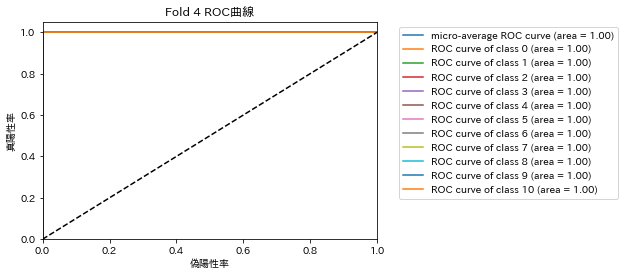

In [ ]:
n_classes = 11

# 学習・推論
skf = StratifiedKFold(
    n_splits=5, 
    shuffle=True,
    random_state=SEED
    )

cv_result_over = []
cv_rmse_over = []

for i, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    X_train_skf, X_test_skf = X_train_over.drop("Global_Sales", axis=1).iloc[train_index], X_train_over.drop("Global_Sales", axis=1).iloc[test_index]
    y_train_skf, y_test_skf = y_train_over.iloc[train_index], y_train_over.iloc[test_index]

    print(f"fold:{i}")

    # データ分布
    histgram = pd.concat([
            y_train_skf.value_counts(normalize=True).sort_index(),
            y_test_skf.value_counts(normalize=True).sort_index()
        ], axis=1).T
    
    histgram.columns = hit_labels
    histgram.index = ["Train", "Test"]

    print("データ分布")
    display(histgram)

    # 学習、推論
    pipe.fit(X_train_skf, y_train_skf)

    y_pred = pipe.predict(X_test_skf)

    # 混合行列のカラム名の作成
    confuse_matrix_columns = np.concatenate([y_test_skf.unique(), np.unique(y_pred)])
    confuse_matrix_columns = np.unique(confuse_matrix_columns)
    confuse_matrix_columns = [hit_labels[x] for x in confuse_matrix_columns]

    print("混合行列")
    display(
        pd.DataFrame(
            confusion_matrix(y_test_skf, y_pred),
            index = confuse_matrix_columns,
            columns = confuse_matrix_columns
        )
    )

    # ROC曲線
    y_score = pipe.predict_proba(X_test_skf)
    y_test_skf_bin = label_binarize(y_test_skf, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for j in range(n_classes):
        fpr[j], tpr[j], _ = roc_curve(y_test_skf_bin[:, j], y_score[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_skf_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
    for k in range(n_classes):
        plt.plot(fpr[k], tpr[k], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(k, roc_auc[k]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('偽陽性率')
    plt.ylabel('真陽性率')
    plt.title(f'Fold {i} ROC曲線')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
    print()
    print()

    pred = pipe.predict(X_test.drop("Global_Sales", axis=1))
    score = f1_score(y_test, pred, average="macro")
    cv_result_over.append(score)

    rmse = mean_squared_error(
            X_test["Global_Sales"], 
            [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, df["Global_Sales"].max()][x] for x in pred],
            squared=False
            )
    cv_rmse_over.append(rmse)

In [ ]:
print("テストデータに対する F1Score:", np.mean(cv_result_over))
print("テストデータに対する RMSE:", np.mean(cv_rmse_over))

テストデータに対する F1Score: 0.9986972627154034
テストデータに対する RMSE: 0.3375619095795954


## Stacking

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

In [ ]:
models = {
    "logistic":LogisticRegression(random_state=SEED),
    "kneighbor":KNeighborsClassifier(),
    "mlp":MLPClassifier(random_state=SEED),
    "svc":SVC(random_state=SEED),
    "adaboost":AdaBoostClassifier(random_state=SEED),
    "random_forest":RandomForestClassifier(random_state=SEED),
    "gradient":GradientBoostingClassifier(random_state=SEED),
    "catboost":CatBoostClassifier(random_state=SEED, 
                                 silent=True, # ログを非表示
                                task_type='GPU', # GPU使用設定
                                 ),
    "xgboost":xgb.XGBClassifier(
        random_state=SEED,
        objective='multi:softmax',
        tree_method='gpu_hist',  # GPU使用設定
        gpu_id=0                 # GPU使用設定
        ),
    "lightgbm":lgb.LGBMClassifier(
        random_state=SEED,
        ),
}

## 一層目

In [ ]:
n_classes = 11

# 学習・推論
skf = StratifiedKFold(
    n_splits=5, 
    shuffle=True,
    random_state=SEED
    )

pred_train = pd.DataFrame()
pred_test = pd.DataFrame()

cv_result_stck = {}

for i, (model_name, model) in enumerate(models.items()):

    print(i, model)

    # パイプライン全体の設定
    step = [
        ("columns_transformers", columns_transformers),
        ('model', model)
     ]

    # パイプラインの作成
    pipe = Pipeline(
        step
    )

    each_model_train = pd.DataFrame()
    each_model_test = pd.DataFrame()

    each_model_result = []

    for j, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        X_train_skf, X_test_skf = X_train.drop("Global_Sales", axis=1).iloc[train_index], X_train.drop("Global_Sales", axis=1).iloc[test_index]
        y_train_skf, y_test_skf = y_train.iloc[train_index], y_train.iloc[test_index]

        # 学習、推論
        pipe.fit(X_train_skf, y_train_skf)

        pickle.dump(pipe["model"], open(f"model_{model_name}_{j}.pkl", 'wb'))

        y_pred = pipe.predict(X_test_skf)

        tmp_train = pd.DataFrame(
                [y_pred.flatten()], # 平坦化
                columns=test_index
            )

        score = f1_score(y_test_skf, y_pred, average="macro")
        each_model_result.append(score)
        each_model_train = pd.concat([each_model_train , tmp_train.T]) # 各KFold ごとの予測結果をDataFrameに縦に並べる

    for j, (train_index, test_index) in enumerate(skf.split(X_test, [0]*len(X_test))):
        X_train_skf, X_test_skf = X_test.drop("Global_Sales", axis=1).iloc[train_index], X_test.drop("Global_Sales", axis=1).iloc[test_index]

        load_model = pickle.load(open(f"model_{model_name}_{j}.pkl", 'rb'))

        # パイプライン全体の設定
        load_step = [
            ("columns_transformers", columns_transformers),
            ('model', load_model)
        ]

        # パイプラインの作成
        load_pipe = Pipeline(
            load_step
        )

        pred = load_pipe.predict(X_test_skf)

        tmp_test = pd.DataFrame(
                [pred.flatten()], # 平坦化
                columns=test_index
            )

        each_model_test = pd.concat([each_model_test , tmp_test.T]) # 各KFold ごとの予測結果をDataFrameに縦に並べる
 
    cv_result_stck[model_name] = each_model_result # 各モデルのf1スコアを集計

    # 学習用の予測データ作成
    each_model_train.columns = [model_name] # カラム名をモデル名に変更
    pred_train = pd.concat([pred_train, each_model_train.sort_index()], axis=1) # 予測結果集計用DataFrameに各モデルの予測結果をくっつける

    # テスト用の予測データ作成
    each_model_test.columns = [model_name] # カラム名をモデル名に変更
    pred_test = pd.concat([pred_test, each_model_test.sort_index()], axis=1) # 予測結果集計用DataFrameに各モデルの予測結果をくっつける

0 LogisticRegression(random_state=42)
1 KNeighborsClassifier()
2 MLPClassifier(random_state=42)
3 SVC(random_state=42)
4 AdaBoostClassifier(random_state=42)
5 RandomForestClassifier(random_state=42)
6 GradientBoostingClassifier(random_state=42)
7 <catboost.core.CatBoostClassifier object at 0x7f5a860b5dd0>
8 XGBClassifier(gpu_id=0, objective='multi:softmax', random_state=42,
              tree_method='gpu_hist')
9 LGBMClassifier(random_state=42)


In [ ]:
print(len(pred_train), len(pred_test))

display(pred_train.head())
display(pred_train.head())

13590 5825


,logistic,kneighbor,mlp,svc,adaboost,random_forest,gradient,catboost,xgboost,lightgbm
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


,logistic,kneighbor,mlp,svc,adaboost,random_forest,gradient,catboost,xgboost,lightgbm
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


### ベストスコアモデルの選定

In [ ]:
best_model_score = 0
best_model_name = ""

In [ ]:
for model_name, f1score in cv_result_stck.items():
    print(model_name, np.mean(f1score))

    if best_model_score < np.mean(f1score):
        best_model_score = np.mean(f1score)
        best_model_name = model_name

print()
print("Best Model is ", best_model_name, "! Best Score is ", best_model_score, "!")

logistic 0.09035313505672425
kneighbor 0.09291644081877312
mlp 0.11015595330137307
svc 0.09036116103514505
adaboost 0.4292619012974509
random_forest 0.49770355314340337
gradient 0.9391359225535506
catboost 0.5109665774376353
xgboost 0.5189826613966799
lightgbm 0.15411815818209879

Best Model is  gradient ! Best Score is  0.9391359225535506 !


### 2階層目 各モデルの予測結果をもとに予測

In [ ]:
# 学習・推論
skf = StratifiedKFold(
    n_splits=5, 
    shuffle=True,
    random_state=SEED
    )

cv_result_stck = []
cv_rmse_stck = []

step = [
    ("numeric_transformers", numeric_transformer), # 全て数値カラムなので、数値カラムのTransformerに変更
    ('model', models[best_model_name]) # 最もスコアの良かったモデルを使用
]

# パイプラインの作成
pipe = Pipeline(
    step
)

for train_index, test_index in skf.split(pred_train, y_train):

    X_train_skf, X_test_skf = pred_train.iloc[train_index], pred_train.iloc[test_index]
    y_train_skf, y_test_skf = y_train.iloc[train_index], y_train.iloc[test_index]

    pipe.fit(X_train_skf, y_train_skf)
    y_pred = pipe.predict(X_test_skf)
    print("F1スコア", f1_score(y_test_skf, y_pred, average="macro"))

    pred = pipe.predict(pred_test)
    score = f1_score(y_test, pred, average="macro")
    cv_result_stck.append(score)

    rmse = mean_squared_error(
            X_test["Global_Sales"], 
            [[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, df["Global_Sales"].max()][x] for x in pred],
            squared=False
            )
    cv_rmse_stck.append(rmse)

F1スコア 0.8141182390138284
F1スコア 0.86778229182545
F1スコア 0.7304473304473305
F1スコア 0.8314765995295705
F1スコア 0.7136530136530136


In [ ]:
print("F1スコア:", np.mean(cv_result_stck))
print("RMSE:", np.mean(cv_rmse_stck))

F1スコア: 0.5782900285036405
RMSE: 0.39725272490719277


## 評価まとめ

In [ ]:
print("通常 対テストデータ F1Score:", round(np.mean(cv_result), 3), "RMSE:", round(np.mean(cv_rmse), 3))
print("オーバーサンプリング 対テストデータ F1Score:", round(np.mean(cv_result_over), 3), "RMSE:", round(np.mean(cv_rmse_over), 3))
print("Stacking 対テストデータ F1スコア:", round(np.mean(cv_result_stck), 3), "RMSE:", round(np.mean(cv_rmse_stck), 3))

通常 対テストデータ F1Score: 0.159 RMSE: 1.255
オーバーサンプリング 対テストデータ F1Score: 0.999 RMSE: 0.338
Stacking 対テストデータ F1スコア: 0.578 RMSE: 0.397
